In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Сренеквадратичное отколонение
mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
#Нормализация
norm = lambda ar: np.array([[(j - i.min())/i.max() for j in i] for i in ar])
#Стандартизация
stand = lambda ar: np.array([(i - i.mean())/i.std() for i in ar])
# Log loss функция оценки качества классификации
log_loss = lambda y, y_pred: -np.mean(y * np.log(y_pred + 1e-20) + (1 - y) * np.log(-y_pred+1 + 1e-20))
# Cигмойд
sigmoid = lambda z: (1/(np.exp(-z)+1))

In [3]:
#Данные урока
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]])

X_norm = np.vstack([X[0],norm(X[1:])])
X_stand = np.vstack([X[0],stand(X[1:])])

# данные для построения регрессионной модели
#y = np.array([45, 55, 50, 59, 65, 35, 75, 80, 50, 60])

# данные для построения моедели классификаци
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [4]:
class LogisticRegressionModel:
    def __init__(self, X=[[1], [1]], y=[1], alpha=0.01, tolerance=1e-05, check_fr=10000, L2=0, L1=0, n_batch=1, X0=True, metric='MSE'):
        self.X0 = X0
        self.X_train = np.array(X) if X0 else p.vstack([np.ones(X.shape[1]), np.array(X)])
        self.W_pred = np.ones(self.X_train.shape[0])
        self.y_train = y
        self.alpha = alpha
        self.tolerance = tolerance
        self.check_fr = check_fr
        self.L2 = L2
        self.L1 = L1
        self.metric = metric
        self.n_batch = n_batch # возможность стахастического градиентного бустинга пока не реализована
        
        self.fit(self.X_train, self.y_train)
    
    def sigmoid(self, z):
        return 1/(np.exp(-z)+1)
    
    def fit(self, X, y):
        self.X_train = np.array(X) if self.X0 else p.vstack([np.ones(X.shape[1]), np.array(X)])
        self.y_train = y
        # Log loss функция оценки качества классификации
        log_loss = lambda y, y_pred: -np.mean(y * np.log(y_pred + 1e-20) + (1 - y) * np.log(-y_pred+1 + 1e-20))
        # Сренеквадраичное отколонение
        mse_err = lambda y, y_pred: np.mean((y - y_pred) ** 2)
        
        i, n,  = 0, len(y)
        err_prev, err_last = 3 * self.tolerance, self.tolerance
        W_pred = np.ones(X.shape[0])
        
        while err_prev - err_last > self.tolerance:
            i += 1
            if i % self.check_fr == 0: 
                err_prev = err_last
            # расчет градиента
            Wg = 2 / n * (W_pred @ X - y) @ X.T 
            # Добавление l2 регуяризации
            Wg += self.L2 * W_pred
            # Добавление l1 регуяризации
            Wg += self.L1 * np.sign(W_pred)    
            W_pred -= self.alpha * Wg
            
            if i % self.check_fr == 0:
                if self.metric == 'MSE':
                    err_last = mse_err(W_pred @ X, y)
                elif self.metric == 'logloss':
                    err_last = log_loss(y, self.sigmoid(W_pred @ X))
        
        self.W_pred = W_pred
    
    def coef_ (self):
        return self.W_pred
    
    def predict(self, X, true_point=0.5):
        return (self.sigmoid(self.W_pred @ X - 0.5) > true_point).astype('int')
    
    def predict_linear(self, X):
        return self.W_pred @ X
    
    def predict_proba(self, X):
        return self.sigmoid(self.W_pred @ X - 0.5)

# САМОСТОЯТЕЛЬНАЯ РАБОТА

### *3.1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  

Добавлена ненулевая компанента 1e-20. Сама по себе не оказывает существенного влияние на расчет но вероятность получить ошибку практически сводится к нулю



In [5]:
log_loss = lambda y, y_pred: sum(-(y * np.log(y_pred+1e-20) + (1 - y) * np.log(-y_pred+1+1e-20)) / len(y))

### 3.2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

Сделал функцию, в которой шаг изменение ошибки задается как параметр для остановки. При alpha = 0.01 результат Log_loss оптимальный. Как эталонный Log_Loss взял результат работы МНК. Отличие было только в 14-м знаке

In [6]:
%%time
model_lr = LogisticRegressionModel(X=X_stand, y=y, alpha=0.01, tolerance=1e-5, metric='LogLoss')
W_pred = model_lr.coef_()
print('Расчет метоом градиентноо бустинга:\nВеса признаков: ', W_pred, '\nLogLoss модели:', log_loss(y, sigmoid(W_pred @ X_stand -0.5)))
print('Предсказания: ', ((sigmoid(W_pred @ X_stand - 0.5)) > 0.5).astype('int'), '\nФакт:         ', y)

Расчет метоом градиентноо бустинга:
Веса признаков:  [ 0.5        -0.52314071 -0.2099946   0.82892734] 
LogLoss модели: 0.5640556174556499
Предсказания:  [0 0 1 0 1 0 1 0 0 1] 
Факт:          [0 0 1 0 1 0 1 0 1 1]
Wall time: 132 ms


In [7]:
%%time
#Метод наименьших квадратов
W_mnk = np.linalg.inv(np.dot(X_stand, X_stand.T)) @ X_stand @ y
print('Метод Наименьших Квадратов:\nВеса признаков: ', W_mnk, '\nLogLoss модели:', log_loss(y, sigmoid(W_mnk @ X_stand - 0.5)))

### 3.3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

Метод Наименьших Квадратов:
Веса признаков:  [ 0.5        -0.52314071 -0.2099946   0.82892735] 
LogLoss модели: 0.5640556174266063
Wall time: 998 µs


In [8]:
# Реализовал в виде класса модели - похоже на то как это сделано в sklearn
model_lr = LogisticRegressionModel(X=X_stand, y=y, alpha=0.01)
model_lr.coef_()

array([ 0.5       , -0.52314071, -0.2099946 ,  0.82892734])

In [9]:
model_lr.predict_proba(X_stand)

array([0.44070858, 0.41948182, 0.62900305, 0.43006306, 0.50948808,
       0.45478089, 0.66906608, 0.39013352, 0.4460525 , 0.60340539])

### 3.4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).


In [10]:
# Реализовал в виде класса модели - похоже на то как это сделано в sklearn. 
model_lr = LogisticRegressionModel(X=X_stand, y=y, alpha=0.01)
model_lr.coef_()

array([ 0.5       , -0.52314071, -0.2099946 ,  0.82892734])

In [11]:
model_lr.predict(X_stand)

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

### 3.5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [12]:
class ClassificationScore():
    def __init__(self, y_true, y_pred):
        df = pd.DataFrame({'True class':y_true, 'y_pred':y_pred})  
        
        for i in df['True class'].value_counts().index: 
            df[i] = (df['y_pred'] == i).astype('int')
        self.df = df
    
    def accuracy(self):
        return self.df.loc[self.df['True class'] == self.df['y_pred']].shape[0] /  self.df.shape[0]
    
    def recall(self, cl=1):
        tp = self.df.loc[(self.df['y_pred'] == cl) & (self.df['y_pred'] == self.df['True class'])].shape[0]
        fn = self.df.loc[(self.df['True class'] == cl) & (self.df['y_pred'] != self.df['True class'])].shape[0]
        return tp / (tp + fn)
    
    def precission(self, cl=1):
        tp = self.df.loc[(self.df['y_pred'] == cl) & (self.df['y_pred'] == self.df['True class'])].shape[0]
        fp = self.df.loc[(self.df['y_pred'] == cl) & (self.df['y_pred'] != self.df['True class'])].shape[0]
        return tp / (tp + fp)
    
    def f1(self, cl=1):
        return 2 * self.recall(cl=cl) * self.precission(cl=cl) / (self.recall(cl=cl) + self.precission(cl=cl))
        
    def confusion_matrix(self):
        col_lst = [i for i in self.df['True class'].value_counts().index]
        col_lst.sort()
        return self.df.groupby(by='True class').agg({i:sum for i in col_lst})
    
    def roc_auc(self):
        return '?.????' # нужнеа дороботка
    
    def pr_auc(self):
        return '?.????' # нужнеа дороботка
    
    def report(self):
        print('CLASSIFICATION SCORES REPORT\n\n' + 'Accuracy:  ', round(self.accuracy(), 4), '\n')
        print('{:<6}{:>8}{:>12}{:>9}'.format('Class','Recall','Precission','f1'))
        
        for i in self.df['True class'].value_counts().index:
            print('{:<6}{:>8}{:>12}{:>9}'.format(i, round(self.recall(i), 4),round(self.precission(i),4), round(self.f1(i),4)))
        
        print('\nConfusion matrix:')
        print(self.confusion_matrix())

In [13]:
y_pred = model_lr.predict(X_stand)
ClassificationScore(y, y_pred).report()

CLASSIFICATION SCORES REPORT

Accuracy:   0.9 

Class   Recall  Precission       f1
1          0.8         1.0   0.8889
0          1.0      0.8333   0.9091

Confusion matrix:
            0  1
True class      
0           5  0
1           1  4


### 3.6. Могла ли модель переобучиться? Почему?

Модель по сути является моделью линейной регрессии. Поэтому ей свойствены и минусы такой модели - переобучения признаков с небольшими весами на зашумленных данных и, возможно, большие коэффициенты при скорелированных между собой признаках

### *3.7 Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

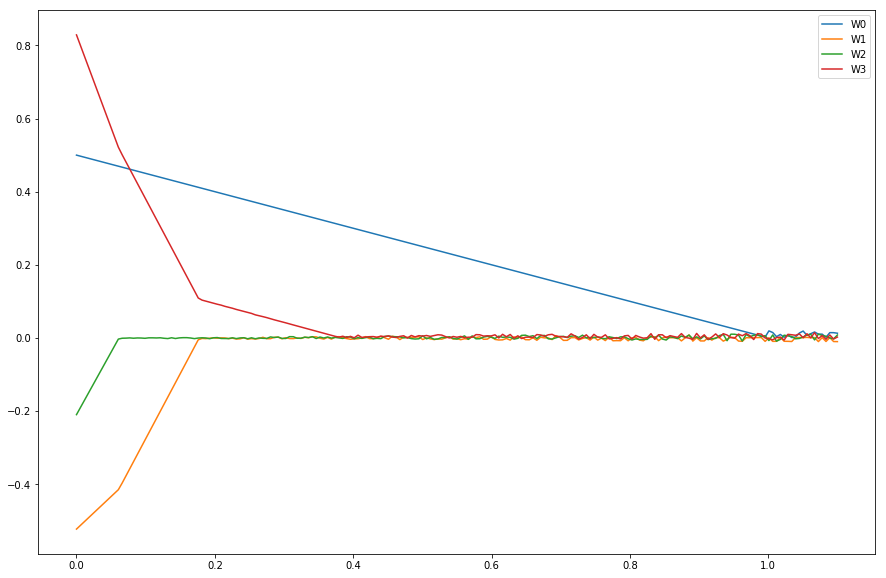

Wall time: 25.4 s


In [14]:
%%time
#Зависимость коэфициентов при прихнаках от L1

L1_plot_data = pd.DataFrame(columns=['L1']+['W'+str(i) for i in range(X.shape[0])] + ['MSE'])

for i in np.linspace(0, 1.1, 201):
    W_pred = LogisticRegressionModel(X_stand, y, alpha=0.01, L1=i).coef_()
    L1_plot_data.loc[L1_plot_data.shape[0]] = [i] + list(W_pred) + [mse_err(X_stand.T @ W_pred, y)]

plt.figure(figsize=(15,10))
for col in L1_plot_data.loc[:,'W0':'W3']:
    plt.plot(L1_plot_data['L1'], L1_plot_data[col], label=col)

plt.legend()
plt.show()

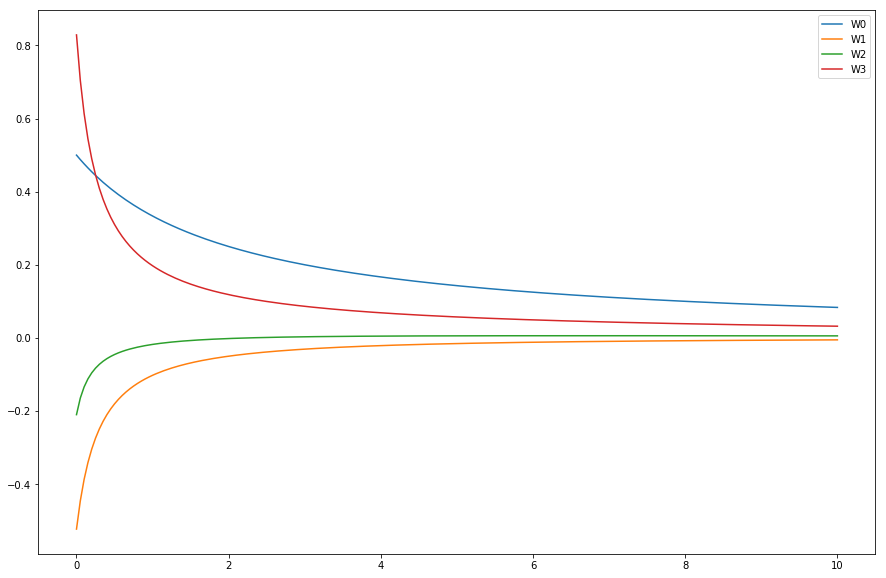

Wall time: 25.9 s


In [15]:
%%time
#Зависимость коэфициентов от L2
L2_plot_data = pd.DataFrame(columns=['L2']+['W'+str(i) for i in range(X.shape[0])] + ['MSE'])

for i in np.linspace(0, 10, 201):
    W_pred = LogisticRegressionModel(X_stand, y, alpha=0.01, L2=i).coef_()
    L2_plot_data.loc[L2_plot_data.shape[0]] = [i] + list(W_pred) + [mse_err(X_stand.T @ W_pred, y)]

plt.figure(figsize=(15,10))
for col in L2_plot_data.loc[:,'W0':'W3']:
    plt.plot(L2_plot_data['L2'], L2_plot_data[col], label=col)

plt.legend()
plt.show()

### Задание 2.1. Построение зависимости W от коэффициента L1

In [ ]:
%%time
#Зависимость коэфициентов от L2
L2_plot_data = pd.DataFrame(columns=['L2']+['W'+str(i) for i in range(X.shape[0])] + ['MSE'])

for i in np.linspace(0, 10, 201):
    W_pred = LogisticRegressionModel(X_stand, y, alpha=0.01, L2=i).coef_()
    L2_plot_data.loc[L2_plot_data.shape[0]] = [i] + list(W_pred) + [mse_err(X_stand.T @ W_pred, y)]

plt.figure(figsize=(15,10))
for col in L2_plot_data.loc[:,'W0':'W3']:
    plt.plot(L2_plot_data['L2'], L2_plot_data[col], label=col)

plt.legend()
plt.show()

In [ ]:
%%time
#Зависимость коэфициентов при прихнаках от L1

L1_plot_data = pd.DataFrame(columns=['L1']+['W'+str(i) for i in range(X.shape[0])] + ['MSE'])

for i in np.linspace(0, 1.1, 201):
    W_pred = LogisticRegressionModel(X_stand, y, alpha=0.01, L1=i).coef_()
    L1_plot_data.loc[L1_plot_data.shape[0]] = [i] + list(W_pred) + [mse_err(X_stand.T @ W_pred, y)]

plt.figure(figsize=(15,10))
for col in L1_plot_data.loc[:,'W0':'W3']:
    plt.plot(L1_plot_data['L1'], L1_plot_data[col], label=col)

plt.legend()
plt.show()

### Задание 2.2 Можно ли к одному и тому же признаку применить сразу и нормализацию, и стандартизацию?





Применение стандартизации и нормализации одновременно не имеет смысла т.к. нормализация подразумеевает приведение к диапазону от 0-1, а стандартизация центрирует признаки вокруг нуля как в плюс так и в минус

### Задание 2.3 Реализовать L1 регуляризацию

In [ ]:
def gradient_boosting(X, y, alpha=0.01, tolerance=1e-5, check_fr=10000, L2=1e-4, L1=1e-4):
    
    W_pred = np.ones(X.shape[0])
    i, n,  = 0, len(y)
    mse_prev, mse_last = 3 * tolerance, tolerance
    
    while mse_prev - mse_last > tolerance:
        i += 1
        if i % check_fr == 0: mse_prev = mse_last
        # расчет градиента
        Wg = 2 / n * (W_pred @ X - y) @ X.T 
        # Добавление l2 регуяризации
        Wg += L2 * W_pred
        # Добавление l1 регуяризации
        Wg += L1 * np.sign(W_pred)
        W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(X.T @ W_pred, y)

    #print('Кол-во итераций:', i, '\nВеса признаков: ', W_pred, '\nMSE модели:', mse_err(X.T @ W_pred, y))
    return W_pred

## Наработки

In [ ]:
%%time
#Метод наименьших квадратов
W_mnk = np.linalg.inv(np.dot(X_stand, X_stand.T)) @ X_stand @ y
W_mnk, mse_err(X_stand.T @ W_mnk, y)
print('\nВеса признаков: ', W_mnk, '\nMSE модели:', mse_err(X_stand.T @ W_mnk, y))

In [ ]:
#Генерация данных для построения модели на базе известной зависимости
def data_generation(x_size=200, W=np.array([-20,-10, 0.5])):
    x0 = np.ones(x_size+1)
    x1 = np.linspace(0, 0.1 * x_size , x_size+1)
    x2 = x1**2
    X = np.vstack([x0,x1,x2])
    y = np.array([int(random.gauss(0, 10)) + i for i in np.dot(W, X)])
    return W, X, y

In [ ]:
#Графическое отображение данных
W, X, y = data_generation()
X_norm = np.vstack([X[0],norm(X[1:])])
X_stand = np.vstack([X[0],stand(X[1:])])

plt.figure(figsize=(10,10))
plt.scatter(np.linspace(0, 0.1 * 200 , 201), y, label='Зашумленные Наблюдения', c='b')
plt.plot(np.linspace(0, 0.1 * 200 , 201), X.T @ W, label='Незашумленные данные', c='g')
plt.legend()

In [ ]:
#Графическое отображение результата работы модели

W_pred = gradient_boosting(X_stand, y, alpha=0.0001)

plt.figure(figsize=(10,10))

plt.scatter(x1, y, label='Наблюдения', c='b')
plt.plot(x1, X.T @ W, label='Незашумленные данные, MSE ' + str(round(mse_err(X.T @ W, y),4)), c='g')
plt.plot(x1, X_stand.T @ W_pred, label='Прогноз методом градиентного бустинга, MSE ' + str(round(mse_err(X.T @ W_pred, y),4)), c='r')
plt.plot(x1, X.T @ W_mnk, label='Прогноз методом наименьших квадратов, MSE ' + str(round(mse_err(X.T @ W_mnk, y),4)), c='y')
plt.legend()
plt.show()

In [ ]:
def log_regression(X, y, alpha=0.01, tolerance=1e-10, check_fr=1000, L2=0, L1=0):
    
    W_pred = np.ones(X.shape[0])
    i, n,  = 0, len(y)
    log_los_prev, log_los_last = 3 * tolerance, tolerance
    
    while abs(log_los_prev - log_los_last) > tolerance:
        i += 1
        if i % check_fr == 0: 
            log_los_prev = log_los_last
        # расчет градиента
        Wg = 2 / n * (W_pred @ X - y) @ X.T 
        # Добавление l2 регуяризации
        Wg += L2 * W_pred
        # Добавление l1 регуяризации
        Wg += L1 * np.sign(W_pred)
        W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            log_los_last = log_loss(y, sigmoid(W_pred @ X-0.5))
            
    return W_pred

In [ ]:
def gradient_boosting(X, y, alpha=0.01, tolerance=1e-5, check_fr=10000, L2=0, L1=0):
    
    W_pred = np.ones(X.shape[0])
    i, n,  = 0, len(y)
    mse_prev, mse_last = 3 * tolerance, tolerance
    
    while mse_prev - mse_last > tolerance:
        i += 1
        if i % check_fr == 0: mse_prev = mse_last
        # расчет градиента
        Wg = 2 / n * (W_pred @ X - y) @ X.T 
        # Добавление l2 регуяризации
        Wg += L2 * W_pred
        # Добавление l1 регуяризации
        Wg += L1 * np.sign(W_pred)
        W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(X.T @ W_pred, y)
    
    return W_pred

In [ ]:
def s_gradient_boosting(X, y, qty_in_batch=5, alpha=0.01, tolerance=1e-5, L2=0, L1=0, check_fr=1000):
    
    W_pred = np.ones(X.shape[0])
    i, n, iter_improve = 0, len(y), 1
    mse_prev, mse_last = 1, 0
    
    n_batch = (n // qty_in_batch + 1) if (n % qty_in_batch) else (n // qty_in_batch)
    print (n_batch)
    while (mse_prev - mse_last) > tolerance:
        i += 1
        if i % check_fr == 0:
            mse_prev = mse_last
        for b in range(n_batch):
            start_ = qty_in_batch * b
            end_ = qty_in_batch * (b + 1)
            X_tmp = X[:, start_:end_]
            y_tmp = y[start_:end_]
            Wg = 2 / n * (W_pred @ X_tmp - y_tmp) @ X_tmp.T
            Wg += L2 * W_pred
            Wg += L1 * np.sign(W_pred)            
            W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(W_pred @ X_tmp, y_tmp)
    
    #print('Кол-во итераций:', i, '\nВеса признаков: ', W_pred, '\nMSE модели:', mse_err(X.T @ W_pred, y))
    return W_pred